# Assignment 5: Neural Networks

Due: November 6th at 11:59pm

**Rohan Jhaveri**

## Exploring neural networks for digit classification 

In this assignment you will explore classification of handwritten digits with neural networks. For that task, we will use part of the MNIST dataset, which is very commonly used in the machine learning community. Your task is to explore various aspects of multi-layer neural networks using this dataset. We have prepared a [small subset](http://www.cs.colostate.edu/~cs545/fall16/lib/exe/fetch.php?media=assignments:mnist.tar.gz) of the data with a given split into training and test data.

1. Plot network accuracy as a function of the number of hidden units for a single-layer network with a logistic activation function. Try to find a range of values where the network displays both under-fitting and over-fitting.  For a fixed architecture, explore accuracy as a function of the number of epochs used for training as well as the learning rate.
2. Plot network accuracy as a function of the number of hidden units for a two-layer network with a logistic activation function, similarly to part 1 using a specific value of the learning rate and number of epochs. Does this dataset benefit from the use of more than one layer?
3.  Add weight decay regularization to the neural network class (explain in your report how you did it). Does the network demonstrate less over-fitting on this dataset with the addition of weight decay?
4. Modify the code to include the option of using the cross-entropy loss function instead of the quadratic loss function.  Run experiments and determine which activation function works best with the cross-entropy (consider logistic and ReLU activations for the hidden layers).  Explain in your writeup the required changes in the code.
5. The code provided performs batch gradient descent.  Modify the code to perform stochastic gradient descent.  Explain in your report the change you made, and compare the performance of the resulting network in terms of accuracy and training time.
6. The provided implementation uses the same activation function in each layer. For solving regression problems we need to use a linear activation function to produce the output of the network. Explain why, and what changes need to be made in the code.


**Import Packages**

In [134]:
# Your answer here.
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
plt.rcParams['axes.labelsize'] = 14

**Extract Data**

In [107]:
def Data():
    train_x=np.loadtxt(r"C:\Users\rohanjha\Downloads\MNIST\MNIST_train.csv", delimiter=",")
    test_x=np.loadtxt(r"C:\Users\rohanjha\Downloads\MNIST\MNIST_test.csv", delimiter=",")
    train_y=np.loadtxt(r"C:\Users\rohanjha\Downloads\MNIST\MNIST_train_labels.csv")
    test_y=np.loadtxt(r"C:\Users\rohanjha\Downloads\MNIST\MNIST_test_labels.csv")
    return train_x,test_x,train_y,test_y

def Standardize_Data():
    train_x,test_x,train_y,test_y = Data()
    x_scale = StandardScaler()
    standardized_train_x = x_scale.fit_transform(train_x)
    standardized_test_x = x_scale.fit_transform(test_x)
    return standardized_train_x,standardized_test_x,train_y,test_y 

x_train,x_test,y_train,y_test = Standardize_Data()
np.unique(x_train)

array([-1.29147171, -1.28567606, -1.28217748, ..., 31.60696126,
       31.60696126, 31.60696126])

**Activation functions**

In [108]:
# the common activation functions:

def logistic(x):
    return 1/(1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(x, 0)

# and their derivatives:

def tanh_deriv(x):
    return 1.0 - np.tanh(x)**2

def logistic_deriv(x):
    return logistic(x)*(1-logistic(x))

def relu_deriv(x) :
    deriv = x.copy()
    deriv[deriv < 0] = 0
    return deriv


**Neural Networks Class**

In [109]:
class NeuralNetwork :
    def __init__(self, architecture, activation='logistic') :
        self.architecture = architecture
        if activation == 'logistic':
            self.activation = logistic
            self.activation_deriv = logistic_deriv
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_deriv = tanh_deriv
        elif activation == 'relu':
            self.activation = relu
            self.activation_deriv = relu_deriv
        else :
            raise ValueError('Activation does not match options')
        self.initialize_weights()
    
    def shuffle_set(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
        
    def initialize_weights(self) :
        W = {}
        b = {}
        for l in range(1, len(self.architecture)):
            W[l] = np.random.random((self.architecture[l], self.architecture[l-1]))
            b[l] = np.random.random((self.architecture[l],))
        self.W, self.b = W, b

    def forward(self, x):
        h = {1: x}
        s = {}
        for l in range(1, len(self.W) + 1):
            s[l+1] = self.W[l].dot(h[l]) + self.b[l]
            h[l+1] = self.activation(s[l+1])
        return h, s
        
    def init_delta_values(self):
        delta_W = {}
        delta_b = {}
        for l in range(1, len(self.architecture)):
            delta_W[l] = np.zeros((self.architecture[l], self.architecture[l-1]))
            delta_b[l] = np.zeros((self.architecture[l],))
        return delta_W, delta_b
    
    def calculate_output_layer_entropy(self, y, h_out):
        return -np.sum(y*(np.log(h_out+1e-6)))

    def calculate_output_layer_delta(self, y, h_out, s_out):
        return -(y-h_out) * self.activation_deriv(s_out)
    
    def calculate_output_layer_ce_delta(self, y, h_out, s_out):
        return -(y/(h_out+1e-6)) * self.activation_deriv(s_out)

    def calculate_hidden_delta(self, delta_plus_1, w_l, s_l):
        return np.dot(np.transpose(w_l), delta_plus_1) * self.activation_deriv(s_l)

    def fit(self, X, y, num_iterations=3000, alpha=0.25, weightDecay=0.00, cross_entropy= False, stochastic_gradient=False):
        iterations = 0
        N = len(y)
        avg_cost_func = []
        while iterations < num_iterations :
            if stochastic_gradient:
                X, y = self.shuffle_set(X,y)
            delta_W, delta_b = self.init_delta_values()
            avg_cost = 0
            for i in range(len(y)):
                delta = {}
                # perform the feed forward pass and return the stored h and z values, to be used in the
                # gradient descent step
                h, s = self.forward(X[i, :])
                # backpropagate the errors
                for l in range(len(self.architecture), 0, -1):
                    if l == len(self.architecture):
                        if cross_entropy:
                            delta[l] = self.calculate_output_layer_ce_delta(y[i,:], h[l], s[l])
                        else:
                            delta[l] = self.calculate_output_layer_delta(y[i,:], h[l], s[l])
                        avg_cost += (np.linalg.norm((y[i,:]-h[l])) / N)
                    else:
                        if l > 1:
                            delta[l] = self.calculate_hidden_delta(delta[l+1], self.W[l], s[l])
                        if stochastic_gradient:
                            delta_W[l] = np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis]))
                            delta_b[l] = delta[l+1]
                            self.W[l] += -alpha * delta_W[l]
                            self.b[l] += -alpha * delta_b[l]
                        else:
                            delta_W[l] += (np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis])) + (weightDecay*self.W[l]))
                            delta_b[l] += (delta[l+1] + (weightDecay*self.b[l]))
            if not stochastic_gradient:
                # perform the gradient descent step for the weights in each layer
                for l in range(len(self.architecture) - 1, 0, -1):
                    self.W[l] += -alpha * (1.0/N * delta_W[l]) 
                    self.b[l] += -alpha * (1.0/N * delta_b[l])                    
            # complete the average cost calculation
            avg_cost_func.append(avg_cost)
            iterations += 1
        return avg_cost_func

    def predict(self, X):
        N = X.shape[0]
        y = np.zeros((N,))
        for i in range(N):
            h, _ = self.forward(X[i, :])
            y[i] = np.argmax(h[len(self.architecture)])
        return y

    def decision_function(self, X):
        N = X.shape[0]
        scores = np.zeros((N,self.architecture[-1]))
        for i in range(N):
            h, _ = self.forward(X[i, :])
            scores[i]=h[len(self.architecture)]
        return scores


**Vectorize Labels**

In [110]:
def y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

In [111]:
# convert labels to vectors
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_vec_train = y_to_vect(y_train)
y_vec_test = y_to_vect(y_test)

**Part 1**

In [112]:
# hidden units for single layer
hn=[1,10,20,30,50,100]
accuracy_train=[]
accuracy_test=[]
for i in hn:
    architecture = [784,i,10]
    network = NeuralNetwork(architecture, 'logistic')
    cost_function = network.fit(x_train, y_vec_train, 1000)
    train_predict = network.predict(x_train)
    accuracy_train.append(accuracy_score(y_train, train_predict) * 100)
    test_predict = network.predict(x_test)
    accuracy_test.append(accuracy_score(y_test, test_predict) * 100)

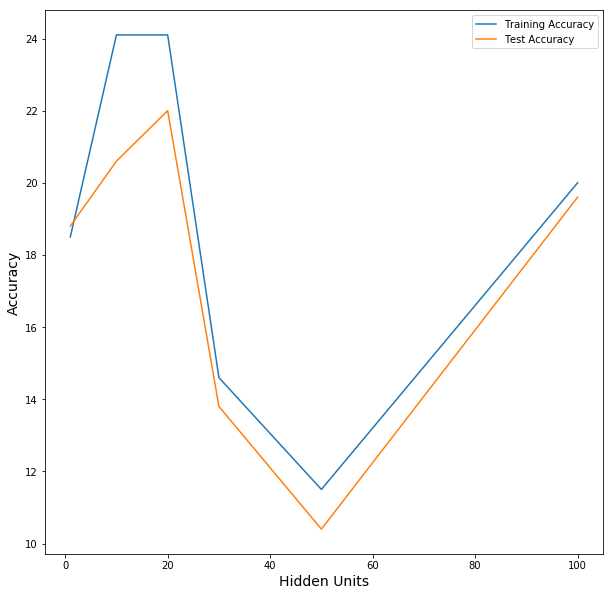

In [113]:
plt.figure(figsize=(10, 10))
plt.plot(hn,accuracy_train,label='Training Accuracy')
plt.plot(hn,accuracy_test,label='Test Accuracy')
plt.xlabel('Hidden Units')
plt.ylabel('Accuracy')
plt.legend()

The number of units in hidden layer ranged from 1-100, the maximum accuracy of approximately 24% for training data and approximately 22% for test data was achieved at 20 hidden units. We can see from the graph that the underfitting and overfitting conditions are exhibited. Underfitting is observed from approximately 1 to 20 hidden units and  slight Overfitting is observed above 30 hidden units. Taking more units should further increase overfitting.

In [114]:
# architecture
architecture = [784, 20, 10]
network = NeuralNetwork(architecture, 'logistic')
epochs = [100,500,1000,1500,2000,2500]
accuracy_train=[]
accuracy_test=[]
for i in epochs:
    cost_function = network.fit(x_train, y_vec_train, i)
    train_predict = network.predict(x_train)
    accuracy_train.append(accuracy_score(y_train, train_predict) * 100)
    test_predict = network.predict(x_test)
    accuracy_test.append(accuracy_score(y_test, test_predict) * 100)

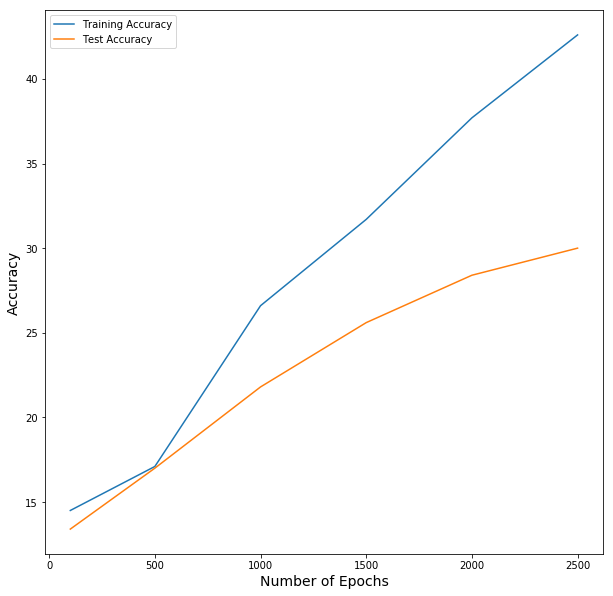

In [115]:
plt.figure(figsize=(10, 10))
plt.plot(epochs,accuracy_train,label='Training Accuracy')
plt.plot(epochs,accuracy_test,label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()

The accuracy increases with number of epochs as seen from the graph. It can also be seen that the data is underfitted till 500 epochs. At 500 epochs the the accuracy of training and testing is the same after which the the accuray of training increases at a faster rate than accuracy of test data due to overfitting.   

In [116]:
# architecture
architecture = [784, 20, 10]
network = NeuralNetwork(architecture, 'logistic')
learning_rate = [0.5,1,2,5,10]
accuracy_train=[]
accuracy_test=[]
for i in learning_rate:
    cost_function = network.fit(x_train, y_vec_train, 1000, i)
    train_predict = network.predict(x_train)
    accuracy_train.append(accuracy_score(y_train, train_predict) * 100)
    test_predict = network.predict(x_test)
    accuracy_test.append(accuracy_score(y_test, test_predict) * 100)

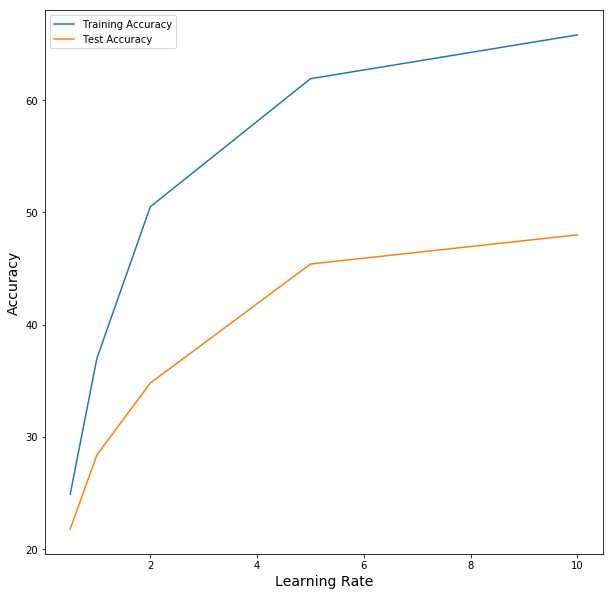

In [118]:
plt.figure(figsize=(10, 10))
plt.plot(learning_rate,accuracy_train,label = 'Training Accuracy')
plt.plot(learning_rate,accuracy_test,label = 'Test Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()

The graph shows that at lower learning rate increases the difference between the training and test accuracy is very similar which gives us the evidence of underfitting whereas as at larger learning rate it shows evidence of overfitting as the difference between the accuracy with respect of learning rate is large.

**Part 2**

In [119]:
# hidden units for two layers
hn=[[1,2],[2,3],[5,10],[15,20],[20,30],[50,100]]
accuracy_train=[]
accuracy_test=[]
for i,j in hn:
    architecture = [784,i,j,10]
    network = NeuralNetwork(architecture, 'logistic')
    cost_function = network.fit(x_train, y_vec_train, 1000, 10)
    train_predict = network.predict(x_train)
    accuracy_train.append(accuracy_score(y_train, train_predict) * 100)
    test_predict = network.predict(x_test)
    accuracy_test.append(accuracy_score(y_test, test_predict) * 100)

<Figure size 720x720 with 0 Axes>

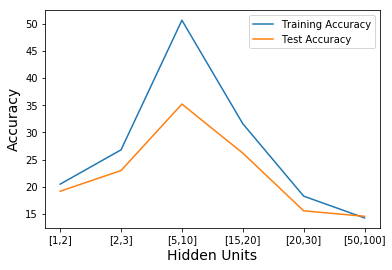

In [120]:
fig, ax = plt.subplots()
fig.canvas.draw()
ax.plot(accuracy_train,label='Training Accuracy')
ax.plot(accuracy_test,label='Test Accuracy')
ax.set_xticks(np.arange(6))
ax.set_xticklabels(('[1,2]','[2,3]','[5,10]','[15,20]','[20,30]','[50,100]'))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Hidden Units')
ax.legend()

Using two layer networks gives us a little improvement in terms of accuracy. The maximum of approximately 50% for training and 35% for test data was achieved at [5,10] hidden uints. But it is evident that with two layer network as well we see underfitting and overfitting as we say in single layer network.

In [122]:
# architecture
architecture = [784, 15, 20, 10]
network = NeuralNetwork(architecture, 'logistic')
epochs = [100,500,1000,1500,2000,2500]
accuracy_train=[]
accuracy_test=[]
for i in epochs:
    cost_function = network.fit(x_train, y_vec_train, i)
    train_predict = network.predict(x_train)
    accuracy_train.append(accuracy_score(y_train, train_predict) * 100)
    test_predict = network.predict(x_test)
    accuracy_test.append(accuracy_score(y_test, test_predict) * 100)

<Figure size 720x720 with 0 Axes>

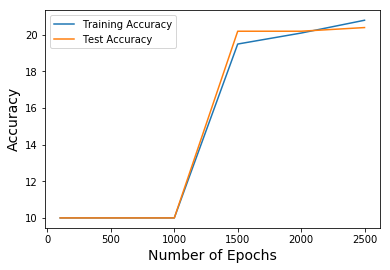

In [123]:
fig, ax = plt.subplots()
fig.canvas.draw()
ax.plot(epochs,accuracy_train,label='Training Accuracy')
ax.plot(epochs,accuracy_test,label='Test Accuracy')
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Accuracy')
ax.legend()

For two layer network, increasing the number of epochs also inreases the computation even futher and hence it tries to generalize dataset rather than learning and hence increases underfitting and overfitting as compared to single layer network.

In [124]:
# architecture
architecture = [784, 15, 20, 10]
network = NeuralNetwork(architecture, 'logistic')
learning_rate = [0.5,1,2,5,10]
accuracy_train=[]
accuracy_test=[]
for i in learning_rate:
    cost_function = network.fit(x_train, y_vec_train, 1000, i)
    train_predict = network.predict(x_train)
    accuracy_train.append(accuracy_score(y_train, train_predict) * 100)
    test_predict = network.predict(x_test)
    accuracy_test.append(accuracy_score(y_test, test_predict) * 100)

<Figure size 720x720 with 0 Axes>

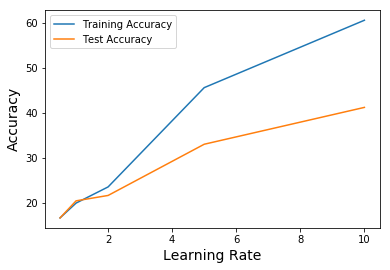

In [125]:
fig, ax = plt.subplots()
fig.canvas.draw()
ax.plot(learning_rate,accuracy_train,label = 'Training Accuracy')
ax.plot(learning_rate,accuracy_test,label = 'Test Accuracy')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
ax.legend()

The learning rate with two layer network also shows a similar results of underfitting and overfitting as in a single layer network. Infact with two layers the compuation time required increases even further. And since, in this case increasing the layer shows no benefit to the network, it is not worth adding more layers to the neural network for this dataset.

**Part 3**

In [126]:
# architecture
architecture = [784,20,10]
accuracy_train=[]
accuracy_test=[]
weight_decay=[0.00002, 0.0005, 0.0075, 0.01, 0.025]
network = NeuralNetwork(architecture, 'logistic')
for i in weight_decay:
    cost_function = network.fit(x_train, y_vec_train, 1000, alpha=10, weightDecay=i)
    train_predict = network.predict(x_train)
    accuracy_train.append(accuracy_score(y_train, train_predict) * 100)
    test_predict = network.predict(x_test)
    accuracy_test.append(accuracy_score(y_test, test_predict) * 100)

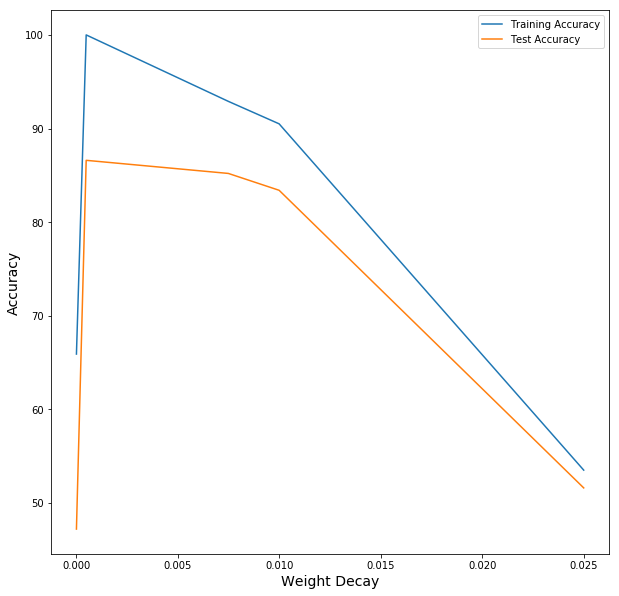

In [128]:
plt.figure(figsize=(10, 10))
plt.plot(weight_decay,accuracy_train,label='Training Accuracy')
plt.plot(weight_decay,accuracy_test,label='Test Accuracy')
plt.xlabel('Weight Decay')
plt.ylabel('Accuracy')
plt.legend()

Weight decay can help regularize the weights and prevent them from getting too large. Using a small weight decay factor, we can slightly decrease the weights.This approach can help prevent overfitting as seen from the graph above. There are many ways to add the weight decay, the approach used in this assignment was to modify these lines of codes before performing gradient descent:

delta_W[l] += (np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis])) + (weightDecay*self.W[l]))

delta_b[l] += (delta[l+1] + (weightDecay*self.b[l]))

(Default the value of weightDecay is 0, unless some value is given in the fit function)

Essentially we multiply the weight decay parameter with the weight and bias and add it to delta i.e. backpropogation parameter while calculting the change in the weights and bias.
We can take a weight decay value between (0.00002,0.025), the higher the value, the more the decay. If the decay is more, the weights take a longer time to converge. In this assignment, the decay value of approximately 0.0005 gave us the highest accuracy.

**Part 4**

In [129]:
# architecture
architecture = [784, 20, 10]
network_logistic = NeuralNetwork(architecture, 'logistic')
cost_function = network_logistic.fit(x_train, y_vec_train, 2500, alpha=10, cross_entropy=True)
train_predict1 = network_logistic.predict(x_train)
test_predict1 = network_logistic.predict(x_test)
accuracy_train = accuracy_score(y_train, train_predict1) * 100
accuracy_test = accuracy_score(y_test, test_predict1) * 100
print('Accuracy for Cross Entropy loss function using logistic activation function for Training in percentage is %f'% accuracy_train)
print('Accuracy for Cross Entropy loss function using logistic activation function for Test in percentage is %f'% accuracy_test)

Accuracy for Cross Entropy loss function using logistic activation function for Training in percentage is 13.400000
Accuracy for Cross Entropy loss function using logistic activation function for Test in percentage is 13.600000


In [130]:
network_relu = NeuralNetwork(architecture, 'relu')
cost_function = network_relu.fit(x_train, y_vec_train, 2500, alpha=10, cross_entropy=True)
train_predict2 = network_relu.predict(x_train)
test_predict2 = network_relu.predict(x_test)
accuracy_train = accuracy_score(y_train, train_predict2) * 100
accuracy_test = accuracy_score(y_test, test_predict2) * 100
print('Accuracy for Cross Entropy loss function using ReLu activation function for Training in percentage is %f'% accuracy_train)
print('Accuracy for Cross Entropy loss function using ReLu activation function for Test in percentage is %f'% accuracy_test)

C:\Users\rohanjha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in multiply
C:\Users\rohanjha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


Accuracy for Cross Entropy loss function using ReLu activation function for Training in percentage is 10.000000
Accuracy for Cross Entropy loss function using ReLu activation function for Test in percentage is 10.000000


With **Cross Entropy** loss function **Logistic** activation function performs better for a single layer neural network with architecture = [784, 20, 10]. The accuracy for logistic activation function is 13.6% whereas for ReLU activation, the accuracy is 10%.

In order to include Cross Entropy loss function, the following lines of code code were added:

def calculate_output_layer_ce_delta(self, y, h_out, s_out):

       return -(y/(h_out+1e-6) * self.activation_deriv(s_out)

(Default value of cross_entropy is False unless passed as True in the fit function) 
        
Basically, we created a funtion to calculate delta i.e. backpropogation parameter which takes into account the derivative of signal output and multiply it by negative value of fraction of labels and hidden layer output added with a very small value to hidden layer output to avoid NaN. This baiscally means we calculate the cross entropy of the signal output and the hidden layer output and based on that we calculate the loss.  

**Part 5**

In [135]:
# architecture
architecture = [784, 20, 10]
start_time=time.time()
network = NeuralNetwork(architecture, 'logistic')
cost_function = network.fit(x_train, y_vec_train, 2500, alpha=10,weightDecay= 0, stochastic_gradient=False)
end_time=time.time()
time_taken=end_time-start_time
train_predict = network.predict(x_train)
test_predict = network.predict(x_test)
accuracy_train = accuracy_score(y_train, train_predict) * 100
accuracy_test = accuracy_score(y_test, test_predict) * 100
print('Accuracy for Batch Gradient Descent for Training in Percentage is %f' %accuracy_train)
print('Accuracy for Batch Gradient Descent for Test in Percentage is %f' %accuracy_test)
print('Time Taken for training',time_taken)


Accuracy for Batch Gradient Descent for Training in Percentage is 65.600000
Accuracy for Batch Gradient Descent for Test in Percentage is 47.600000
Time Taken for training 818.8062856197357


In [136]:
start_time=time.time()
network_stochastic = NeuralNetwork(architecture, 'logistic')
cost_function = network_stochastic.fit(x_train, y_vec_train, 2500, alpha=10, stochastic_gradient=True)
end_time=time.time()
time_taken=end_time-start_time
train_predict = network_stochastic.predict(x_train)
test_predict = network_stochastic.predict(x_test)
accuracy_train = accuracy_score(y_train, train_predict) * 100
accuracy_test = accuracy_score(y_test, test_predict) * 100
print('Accuracy for Stochastic Gradient Descent for Training in Percentage is %f' %accuracy_train)
print('Accuracy for Stochastic Gradient Descent for Test in Percentage is %f' %accuracy_test)
print('Time Taken for training',time_taken)

Accuracy for Stochastic Gradient Descent for Training in Percentage is 58.900000
Accuracy for Stochastic Gradient Descent for Test in Percentage is 58.000000
Time Taken for training 730.5912706851959


In order to calculate the stochastic gradient descent, the following lines of codes were added:

if stochastic_gradient:

    delta_W[l] = np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis]))
    delta_b[l] = delta[l+1]
    self.W[l] += -alpha * delta_W[l]
    self.b[l] += -alpha * delta_b[l]
                           
(Default value of stochastic_gradient is False unless passed as True in the fit function)

Basically, here we update the weight and bias after the gradient descent is calculated for a particular training example instead of aggregating the gradient descent for all training example and then updating the weight and bias. 

It can be seen that the accuracy of testing data for stochastic gradient descent (58%) is more than accuracy of testing data for batch gradient descent (47.6%) as stochastic gradient descent leads to better local minima. 

Also, the training time is less for stochastic gradient descent (730.591s) as compared to batch gradient descent (818.806s) as there are several duplicates of an example in a dataset and updates made from duiplcates do not contribute to convergence.

**Part 6**

In linear activation function, the output will be a real value rather than discrete value. In case of regression, the output values don't strictly need to be within a certain range, but could have arbitrary (real) values. Imposing a restrictive activation function like Tanh or logistic would require us to scale all the outputs to be within the range, and it still doesn't consider that the test outputs are out of that range. Hence for solving regression problem we should use linear activation function to produce output of a network. The cons of this activation function is that stochastic gradient is constant and hence changes made by backpropogation is indpendent of change in input delta. We can use stochastic ascent instead of stochastic descent. 

The changes to be made in the code are that we need to remove np.argmax(h[len(self.architecture)]) from predict function so that we get probabilities as required for regression.

### Your Report

Answer the questions in the cells reserved for that purpose.

Mathematical equations should be written as LaTex equations; the assignment contains multiple examples of both inline formulas (such as the one exemplifying the notation for the norm of a vector $||\mathbf{x}||$ and those that appear on separate lines, e.g.:

$$
||\mathbf{x}|| = \sqrt{\mathbf{x}^T \mathbf{x}}.
$$



### Submission

Submit your report as a Jupyter notebook via Canvas.  Running the notebook should generate all the plots and results in your notebook.


### Grading 

Here is what the grade sheet will look like for this assignment.  A few general guidelines for this and future assignments in the course:

  * Your answers should be concise and to the point.  We will take off points if that is not the case.
  * Always provide a description of the method you used to produce a given result in sufficient detail such that the reader can reproduce your results on the basis of the description.  You can use a few lines of python code or pseudo-code.


Grading sheet for the assignment:

```
Neural networks.
(15 points):  Exploration of a network with a single hidden layer
(15 points):  Exploration of a network with two hidden layers
(15 points):  Regularization
(20 points):  Cross-entropy
(20 points):  Stochastic gradient descent
(15 points):  Linear activation function for regression
```

Grading will be based on the following criteria:

  * Correctness of answers to math problems
  * Math is formatted as LaTex equations
  * Correct behavior of the required code
  * Easy to understand plots 
  * Overall readability and organization of the notebook
  * Effort in making interesting observations where requested.
  * Conciseness.  Points may be taken off if the notebook is overly 
  